# Phase 1

## Preprocessing



In [2]:
import warnings

import pandas as pd
from dateutil.parser import parse
from tmdbv3api import Movie
from tmdbv3api import TMDb

import keys  # TMDb API key file

warnings.filterwarnings("ignore")

##### Reading the train datasets

In [2]:
# reading csv files
movies_base = pd.read_csv('datasets/1/train/movies-revenue.csv')
movies_director = pd.read_csv('datasets/1/train/movie-director.csv')

##### Checking nulls

In [3]:
movies_base.isnull().sum()

name             0
release_date     0
genre           14
MPAA_rating     47
revenue          0
dtype: int64

##### Joining directors dataset into the movies (main) dataset

In [4]:
# Merging dataframes; how = 'left' := use only keys from left frame.
df = pd.merge(movies_base, movies_director, on='name', how='left')

# displaying result
df.head()

,name,release_date,genre,MPAA_rating,revenue,director
0,Recess: School's Out,16-Feb-01,Comedy,G,"$54,656,124",NaN
1,D2: The Mighty Ducks,25-Mar-94,Comedy,PG,"$94,226,333",NaN
2,Home on the Range,2-Apr-04,Comedy,PG,"$67,910,166",Will Finn
3,Young Black Stallion,25-Dec-03,Adventure,G,"$9,254,344",NaN
4,What's Love Got to Do With It,9-Jun-93,Drama,R,"$79,618,610",NaN


##### Filling the null directors

In [5]:
df.isnull().sum()

name              0
release_date      0
genre            14
MPAA_rating      47
revenue           0
director        428
dtype: int64

In [6]:
df.describe().T

,count,unique,top,freq
name,463,460,Cinderella,2
release_date,463,446,3-Mar-95,2
genre,449,12,Comedy,146
MPAA_rating,416,5,PG,156
revenue,463,461,$0,3
director,35,22,Ron Clements,6


In [7]:
df.dtypes

name            object
release_date    object
genre           object
MPAA_rating     object
revenue         object
director        object
dtype: object

In [8]:
# Formatting the release_date to match the TMDb date format

for i, movie in df.iterrows():
    # Parse date from a string and return a datetime.datetime
    release_date = parse(movie['release_date'])
    # Remove the time from it reducing it to just the date
    release_date = release_date.date()

    # Parser doesn't do well with dates prior to the 80s
    # Correcting the dates newer than this year to a century earlier
    if release_date.year > 2023:
        release_date = release_date.replace(year=release_date.year - 100)

    # Editing the value at the original dataframe
    df.at[i, 'release_date'] = release_date

df['release_date'] = pd.to_datetime(df['release_date'])
df.head(n=10)

,name,release_date,genre,MPAA_rating,revenue,director
0,Recess: School's Out,2001-02-16,Comedy,G,"$54,656,124",NaN
1,D2: The Mighty Ducks,1994-03-25,Comedy,PG,"$94,226,333",NaN
2,Home on the Range,2004-04-02,Comedy,PG,"$67,910,166",Will Finn
3,Young Black Stallion,2003-12-25,Adventure,G,"$9,254,344",NaN
4,What's Love Got to Do With It,1993-06-09,Drama,R,"$79,618,610",NaN
5,Lady and the Tramp,1955-06-22,Drama,G,"$1,236,035,515",Hamilton Luske
6,Corky Romano,2001-10-12,Comedy,PG-13,"$35,705,805",NaN
7,The Waterboy,1998-11-06,Comedy,PG-13,"$288,691,833",NaN
8,Captain America: The Winter Soldier,2014-04-04,Action,PG-13,"$268,013,076",NaN
9,Pirates of the Caribbean: Dead Man’…,2006-07-07,Adventure,PG-13,"$544,817,142",NaN


##### Initializing TMDb API

In [9]:
# Using the TMDb to fill out the missing director from the original dataset

# https://github.com/AnthonyBloomer/tmdbv3api
# https://developers.themoviedb.org/3/getting-started/introduction

# Creating a base class instance from the api library
tmdb = TMDb()
tmdb.api_key = keys.tmdb_key
tmdb.language = 'en'
tmdb.debug = True


##### Using the TMDb API to fill missing directors via the movie title and its release date
Since the director name is still not encoded, the director's popularity score will replace it.

In [10]:
# Creating a Movie instance to search by the movie details
movie = Movie()

for i, mov in df.iterrows():
    search = movie.search(mov['name'])  # Search by the movie title
    for res in search:
        try:
            # Confirming the search results by the release date year
            mov_date_str = str(mov['release_date'])
            if res['release_date'][:4] == mov_date_str[:4]:
                # Extracting the director from the movie credits
                for member in movie.credits(res.id)['crew']:
                    if member['job'] == 'Director':
                        # Editing the value at the original dataframe
                        df.at[i, 'director'] = member['popularity']
                        break
                break
        except BaseException as error:
            print('An exception occurred: {}'.format(error) + " " + mov['name'])

In [11]:
df.isnull().sum()

name             0
release_date     0
genre           14
MPAA_rating     47
revenue          0
director        26
dtype: int64

In [12]:
df.head()

,name,release_date,genre,MPAA_rating,revenue,director
0,Recess: School's Out,2001-02-16,Comedy,G,"$54,656,124",0.814
1,D2: The Mighty Ducks,1994-03-25,Comedy,PG,"$94,226,333",1.048
2,Home on the Range,2004-04-02,Comedy,PG,"$67,910,166",1.975
3,Young Black Stallion,2003-12-25,Adventure,G,"$9,254,344",4.61
4,What's Love Got to Do With It,1993-06-09,Drama,R,"$79,618,610",0.946


##### Cleaning up the revenue to extract the float value

In [13]:
df['revenue'] = df['revenue'].str.replace(',', '').str.replace('$', '').astype('float')
print(df.dtypes)
df.head()

name                    object
release_date    datetime64[ns]
genre                   object
MPAA_rating             object
revenue                float64
director                object
dtype: object


,name,release_date,genre,MPAA_rating,revenue,director
0,Recess: School's Out,2001-02-16,Comedy,G,54656124.0,0.814
1,D2: The Mighty Ducks,1994-03-25,Comedy,PG,94226333.0,1.048
2,Home on the Range,2004-04-02,Comedy,PG,67910166.0,1.975
3,Young Black Stallion,2003-12-25,Adventure,G,9254344.0,4.61
4,What's Love Got to Do With It,1993-06-09,Drama,R,79618610.0,0.946


##### Encoding the MPAA Rating and Genre to indicator variables

In [14]:
# Fill the nulls with the mode
df['director'] = df['director'].fillna(value=df['director'].median())
df['genre'] = df['genre'].fillna(value=df['genre'].mode()[0])
df['MPAA_rating'] = df['MPAA_rating'].fillna(value=df['MPAA_rating'].mode()[0])
df.isnull().sum()

name            0
release_date    0
genre           0
MPAA_rating     0
revenue         0
director        0
dtype: int64

In [15]:
# Preprocessing genre and MPAA_rating

df = pd.get_dummies(df, columns=["MPAA_rating"], prefix=["rating_is"])
df = pd.get_dummies(df, columns=["genre"], prefix=["genre_is"])
df.head()

,name,release_date,revenue,director,rating_is_G,rating_is_Not Rated,rating_is_PG,rating_is_PG-13,rating_is_R,genre_is_Action,...,genre_is_Black Comedy,genre_is_Comedy,genre_is_Concert/Performance,genre_is_Documentary,genre_is_Drama,genre_is_Horror,genre_is_Musical,genre_is_Romantic Comedy,genre_is_Thriller/Suspense,genre_is_Western
0,Recess: School's Out,2001-02-16,54656124.0,0.814,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,D2: The Mighty Ducks,1994-03-25,94226333.0,1.048,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Home on the Range,2004-04-02,67910166.0,1.975,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Young Black Stallion,2003-12-25,9254344.0,4.610,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,What's Love Got to Do With It,1993-06-09,79618610.0,0.946,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
def date_to_float(dt):
    # Calculating the months and days
    calc = (((dt.month - 1) * 30) + dt.day) / 365
    # Adding calc to the years
    return dt.year + calc

##### Splitting date to days and months and then converting it to a scalar via `date_to_float()`

In [17]:
df['month'] = df['release_date'].dt.month
df['day'] = df['release_date'].dt.day
df['season'] = df['release_date'].dt.quarter
df['release_date'] = df['release_date'].apply(date_to_float)
df.head()

,name,release_date,revenue,director,rating_is_G,rating_is_Not Rated,rating_is_PG,rating_is_PG-13,rating_is_R,genre_is_Action,...,genre_is_Documentary,genre_is_Drama,genre_is_Horror,genre_is_Musical,genre_is_Romantic Comedy,genre_is_Thriller/Suspense,genre_is_Western,month,day,season
0,Recess: School's Out,2001.126027,54656124.0,0.814,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,16,1
1,D2: The Mighty Ducks,1994.232877,94226333.0,1.048,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3,25,1
2,Home on the Range,2004.252055,67910166.0,1.975,0,0,1,0,0,0,...,0,0,0,0,0,0,0,4,2,2
3,Young Black Stallion,2003.972603,9254344.0,4.610,1,0,0,0,0,0,...,0,0,0,0,0,0,0,12,25,4
4,What's Love Got to Do With It,1993.435616,79618610.0,0.946,0,0,0,0,1,0,...,0,1,0,0,0,0,0,6,9,2


In [18]:
df.to_csv('datasets/1/train/preprocessed.csv', index=False)

In [31]:
from scipy.stats import stats
# Train a Linear Regression model
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

df = df.drop(['name'], axis=1)

# drop outliers from the dataset via z score
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

X = df.drop(['revenue'], axis=1)
Y = df['revenue']

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Feature Scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Linear Regression to the dataset
regressor = linear_model.LinearRegression()
regressor.fit(X_train, Y_train)

# Predicting the Test set results
Y_pred = regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % metrics.mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % metrics.r2_score(Y_test, Y_pred))


Coefficients: 
 [-1.91251920e+08  9.98980854e+07  4.50903914e+07  2.23517418e-08
  4.77233973e+06 -6.43895890e+06 -4.34237722e+07  5.96046448e-08
  6.05348541e+07  3.72529030e-08 -8.56900466e+06  0.00000000e+00
  0.00000000e+00 -5.19658495e+07  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.24374329e+08
  1.66396961e+07 -1.81530738e+08]
Mean squared error: 48311858652198056.00
Coefficient of determination: 0.24


ValueError: `bins` must increase monotonically, when an array

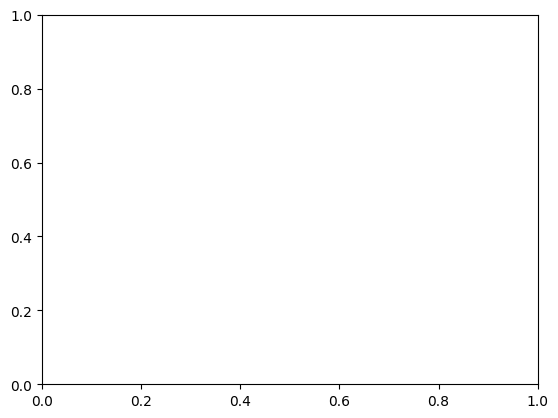

In [32]:
df_not_adjusted = pd.read_csv('datasets/1/train/preprocessed.csv')
df = pd.read_csv('datasets/1/train/preprocessed.csv')

import cpi

# Adjust the revenue to inflation using cpi
df['revenue'] = df.apply(lambda x: cpi.inflate(x['revenue'],
                                               int(x.release_date)), axis=1)
# plot the revenue and the release date
plt.scatter(df_not_adjusted['release_date'], df_not_adjusted['revenue'])
plt.show()

# plot the adjusted revenue and the release date
plt.scatter(df['release_date'], df['revenue'])


In [17]:
df.head()

,name,release_date,revenue,director,rating_is_G,rating_is_Not Rated,rating_is_PG,rating_is_PG-13,rating_is_R,genre_is_Action,...,genre_is_Documentary,genre_is_Drama,genre_is_Horror,genre_is_Musical,genre_is_Romantic Comedy,genre_is_Thriller/Suspense,genre_is_Western,month,day,season
0,Recess: School's Out,2001.126027,8.362603e+07,0.814,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,16,1
1,D2: The Mighty Ducks,1994.232877,1.722841e+08,1.048,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3,25,1
2,Home on the Range,2004.252055,9.741460e+07,1.975,0,0,1,0,0,0,...,0,0,0,0,0,0,0,4,2,2
3,Young Black Stallion,2003.972603,1.362853e+07,4.610,1,0,0,0,0,0,...,0,0,0,0,0,0,0,12,25,4
4,What's Love Got to Do With It,1993.435616,1.493028e+08,0.946,0,0,0,0,1,0,...,0,1,0,0,0,0,0,6,9,2
